In [3]:
import pandas as pd
import math

from tqdm import tqdm
tqdm.pandas()

import copy
from functools import partial
import os

from collections import defaultdict

In [4]:
import pandas as pd

df = pd.read_csv("rba-dataset.csv", parse_dates=["Login Timestamp"])

In [5]:
print(df.columns)


Index(['index', 'Login Timestamp', 'User ID', 'Round-Trip Time [ms]',
       'IP Address', 'Country', 'Region', 'City', 'ASN', 'User Agent String',
       'Browser Name and Version', 'OS Name and Version', 'Device Type',
       'Login Successful', 'Is Attack IP', 'Is Account Takeover'],
      dtype='object')


In [6]:
import pandas as pd
from collections import defaultdict

# Create a defaultdict that automatically creates lists
nested_dict = lambda: defaultdict(list)

# Function to get logs before a given timestamp
def __dataframe_values_before_timestamp(df, timestamp):
    """
    Query logs where time < timestamp.
    Assumes df has DateTimeIndex and is sorted.
    """
    return df.loc[:timestamp][:-1]

# Function to get logs between two timestamps
def __dataframe_values_between_timestamp(df, timestamp_from, timestamp_to):
    """
    Query logs where timestamp_from <= time < timestamp_to.
    Assumes df has DateTimeIndex and is sorted.
    """
    return df.loc[timestamp_from:timestamp_to][:-1]

# Attach custom functions to pandas DataFrame
pd.core.frame.DataFrame.before_timestamp = __dataframe_values_before_timestamp
pd.core.frame.DataFrame.between_timestamp = __dataframe_values_between_timestamp

In [7]:
df = pd.read_csv("rba-dataset.csv", parse_dates=["Login Timestamp"])
df.set_index("Login Timestamp", inplace=True)
df.sort_index(inplace=True)  # Required for .before_timestamp to work efficiently


In [8]:
# Example: show logs before a sample timestamp for a specific user
sample_user = df["User ID"].unique()[0]
user_logs = df[df["User ID"] == sample_user]
timestamp = user_logs.index[2]  # take third login timestamp

logs_before = user_logs.before_timestamp(timestamp)
display(logs_before)


,index,User ID,Round-Trip Time [ms],IP Address,Country,Region,City,ASN,User Agent String,Browser Name and Version,OS Name and Version,Device Type,Login Successful,Is Attack IP,Is Account Takeover
Login Timestamp,,,,,,,,,,,,,,,
2020-02-03 12:43:30.772,0,-4324475583306591935,NaN,10.0.65.171,NO,-,-,29695,Mozilla/5.0 (iPhone; CPU iPhone OS 13_4 like ...,Firefox 20.0.0.1618,iOS 13.4,mobile,False,False,False
2020-02-03 12:43:43.549,1,-4324475583306591935,NaN,194.87.207.6,AU,-,-,60117,Mozilla/5.0 (Linux; Android 4.1; Galaxy Nexus...,Chrome Mobile 46.0.2490,Android 4.1,mobile,False,False,False


In [9]:
class HashTable():
    def __init__(self):
        self.__hash_table = {}

In [10]:
class SubfeatureOccurenceHashTable(HashTable):
    def __init__(self, df, column_name, subfeature, subfeatures):
        self.__hash_table = {}
        self.__subfeature_table = {}

        self.__column_name = column_name
        self.__subfeature = subfeature
        self.__subfeatures = subfeatures[column_name]

        # Group and count occurrences
        self.__hash_table = df.groupby([self.__column_name, subfeature], dropna=False).apply(len)

        # Define subfeature hierarchy to use
        pos = self.__subfeatures.index(self.__subfeature)
        self.__subfeatures_to_use = self.__subfeatures[pos:]

        # Create unique-value subfeature table
        self.__subfeature_table = df.groupby(self.__subfeatures_to_use, dropna=False).apply(lambda x: True)

    def get(self, subfeature, subfeature_value):
        try:
            return self.__hash_table.loc[subfeature_value]
        except KeyError:
            return 0

    def increase(self, log):
        try:
            column_name_value = getattr(log, self.__column_name)
            subfeature_value = getattr(log, self.__subfeature)
        except AttributeError:
            print("ERROR: Subfeature or column name missing in log.")
            return

        try:
            self.__hash_table.loc[(subfeature_value, column_name_value)] += 1
        except (KeyError, TypeError):
            self.__hash_table.loc[(subfeature_value, column_name_value)] = 1
            self.__hash_table.sort_index(inplace=True)

        try:
            for subfeature in self.__subfeatures:
                group_values = [getattr(log, self.__column_name)]
                for pre_sub in self.__subfeatures:
                    group_values.append(getattr(log, pre_sub))
                    if pre_sub == self.__subfeature:
                        break
                group_values = tuple(group_values)
                self.__subfeature_table[subfeature].loc[group_values] = True
                self.__subfeature_table[subfeature].sort_index(inplace=True)
        except Exception:
            pass

    def len(self, subfeature_value):
        return self.get(self.__subfeature, subfeature_value).sum()

    def len_unique(self, next_subfeature):
        if next_subfeature == self.__subfeature:
            return len(self.__hash_table)
        else:
            return len(self.__subfeature_table[next_subfeature])

    def get_hash_table(self, subfeature_value):
        return self.__hash_table.loc[subfeature_value]

    def get_full_hash_table(self):
        return self.__hash_table

    def get_full_subfeature_table(self):
        return self.__subfeature_table

    def get_column_name(self):
        return self.__column_name

    def get_subfeatures(self):
        return self.__subfeatures

    def get_subfeatures_to_use(self):
        return self.__subfeatures_to_use


In [11]:
class OccurenceHashTable(HashTable):
    """
    Class for hash tables containing the occurrences of column values inside a DataFrame
    """

    def __init__(self, df, column_names=[], subfeatures={
        "requestXRealIP": ["ipASN", "ipCountry"],
        "trackingdatauserAgent": ["browser_name_version", "os_name_version", "device_type"]
    }):
        if len(column_names) == 0:
            column_names = df.columns  # Use all columns if not specified

        self.__hash_table = {}
        self.__subfeatures = subfeatures
        self.__length = len(df)

        for column_name in column_names:
            # Count frequencies for each column
            self.__hash_table[column_name] = pd.DataFrame(df.groupby(column_name, dropna=False).size())

            # Handle subfeatures if defined
            if column_name in subfeatures:
                for subfeature in subfeatures[column_name]:
                    self.__hash_table[(column_name, subfeature)] = SubfeatureOccurenceHashTable(
                        df, column_name, subfeature, subfeatures
                    )

    def __str__(self):
        return str(self.__hash_table)

    def get(self, column_name, value):
        """Get the occurrence of a value in the column"""
        try:
            return self.__hash_table[column_name].loc[value].values[0]
        except KeyError:
            return 0

    def get_hash_table(self, column_name):
        """Return the full hash table for a column"""
        return self.__hash_table[column_name]

    def get_subfeature_hash_table(self, column_name, subfeature):
        """Return the subfeature hash table"""
        return self.__hash_table[(column_name, subfeature)]

    def len_unique(self, column_name):
        """Return number of unique values in a column"""
        return len(self.__hash_table[column_name])

    def len(self):
        """Return total row count"""
        return self.__length

    def increase(self, log):
        """Increment values in hash tables based on a log (login record)"""
        for key, value in log._asdict().items():
            if key in self.__hash_table:
                try:
                    self.__hash_table[key].loc[value] += 1
                except KeyError:
                    self.__hash_table[key].loc[value] = 1
                    self.__hash_table[key].sort_index(inplace=True)

                # Update subfeatures if applicable
                if key in self.__subfeatures:
                    for subfeature in self.__subfeatures[key]:
                        self.get_subfeature_hash_table(key, subfeature).increase(log)

        self.__length += 1


In [12]:
class SubfeatureOccurenceHashTableHelper:
    """
    Helper class to adjust functions to RBA algorithm function calls
    """

    def __init__(self, hash_table, column_name, subfeature, subfeature_value, login_attempt):
        """
        Constructor
        
        hash_table -- Global OccurenceHashTable
        column_name -- Main column name (e.g., 'requestXRealIP')
        subfeature -- Subfeature to track (e.g., 'ipASN')
        subfeature_value -- The value of the subfeature to look up
        login_attempt -- Current login tuple for which we calculate values
        """
        self.__hash_table = hash_table
        self.__subfeature = subfeature
        self.__subfeature_value = subfeature_value
        self.__login_attempt = login_attempt
        self.__subfeature_occurence_hash_table = self.__hash_table.get_subfeature_hash_table(column_name, subfeature)

    def len(self):
        """
        Returns the number of times the subfeature value has occurred
        """
        return self.get(self.__subfeature, self.__subfeature_value)

    def get(self, feature, feature_value):
        """
        Look up how many times a value has occurred in the feature's hash table
        """
        return self.__hash_table.get(feature, feature_value)

    def len_unique(self, next_subfeature):
        """
        Returns how many unique values exist for the next_subfeature given the values of all prior subfeatures
        """
        subfeatures_to_use = self.__subfeature_occurence_hash_table.get_subfeatures()

        # Only use subfeatures up to (but not including) the next one
        subfeatures_to_use = subfeatures_to_use[:subfeatures_to_use.index(next_subfeature)]

        # Build tuple of values from current login
        values = tuple(getattr(self.__login_attempt, sf) for sf in subfeatures_to_use)

        try:
            return len(self.__subfeature_occurence_hash_table.get_full_subfeature_table().loc[values])
        except KeyError:
            return 0.0

    def get_hash_table(self):
        """
        Returns the subfeature hash table for the subfeature_value
        """
        return self.__subfeature_occurence_hash_table.get_hash_table(self.__subfeature_value)

    def get_subfeature_occurence_hash_table(self):
        return self.__subfeature_occurence_hash_table


In [13]:

# Weightings for RBA Risk Scoring

feature_weightings = {
    "requestXRealIP": {
        "requestXRealIP": 0.6,
        "ipASN": 0.3,
        "ipCountry": 0.1
    },
    "trackingdatauserAgent": {
        "trackingdatauserAgent": 0.5386653840551359,
        "browser_name_version": 0.2680451498625666,
        "os_name_version": 0.18818295100109536,
        "device_type": 0.0051065150812021525
    }
}

# Overall risk score contribution per top-level feature
risk_score_weightings = {
    "requestXRealIP": 1,
    "trackingdatauserAgent": 1
}


In [14]:
import math
import pandas as pd

# === Feature/Subfeature Weights (used in Freeman's model) ===
feature_weightings = {
    "requestXRealIP": {
        "requestXRealIP": 0.6,
        "ipASN": 0.3,
        "ipCountry": 0.1
    },
    "trackingdatauserAgent": {
        "trackingdatauserAgent": 0.5386653840551359,
        "browser_name_version": 0.2680451498625666,
        "os_name_version": 0.18818295100109536,
        "device_type": 0.0051065150812021525
    }
}

risk_score_weightings = {
    "requestXRealIP": 1,
    "trackingdatauserAgent": 1
}


In [15]:
def get_unseen_values(login_history, feature, hash_table=None):
    for __feature in feature_weightings.keys():
        i = 0
        for subfeature in feature_weightings[__feature].keys():
            if i > len(feature_weightings[__feature]) - 2:
                break
            if feature == subfeature:
                next_subfeature = list(feature_weightings[__feature].keys())[i + 1]
                try:
                    return hash_table.len_unique(next_subfeature) + get_unseen_values(login_history, next_subfeature, hash_table)
                except (AttributeError, NotImplementedError):
                    return len(login_history[next_subfeature].unique()) + get_unseen_values(login_history, next_subfeature, hash_table)
            i += 1
    return 1  # base case

def get_likelihood(login_history, login_attempt, feature, smoothing=True, hash_table=None):
    feature_value = getattr(login_attempt, feature)

    try:
        appearance = hash_table.get(feature, feature_value)
    except:
        appearance = len(login_history.query(f"{feature} == @feature_value"))

    unseen = get_unseen_values(login_history, feature, hash_table) if (smoothing or appearance == 0) else 0

    try:
        num_logs = hash_table.len()
    except:
        num_logs = len(login_history)

    if appearance > 0:
        likelihood = (appearance / num_logs) * (1 - unseen / (num_logs + unseen))
    else:
        likelihood = 1 / (num_logs + unseen) if smoothing else 0.0

    return likelihood

def get_sub_likelihood(user_logs, login_attempt, feature, feature_value, subfeature, smoothing=True, hash_table=None):
    subfeature_value = getattr(login_attempt, subfeature)
    
    try:
        hash_table_subfeature = SubfeatureOccurenceHashTableHelper(hash_table, feature, subfeature, subfeature_value, login_attempt)
    except:
        hash_table_subfeature = None

    user_logs_subfeature = None if hash_table_subfeature else user_logs.query(f"{subfeature} == @subfeature_value")

    likelihood_user_subfeature = get_likelihood(user_logs_subfeature, login_attempt, subfeature, smoothing=smoothing, hash_table=hash_table_subfeature)
    likelihood_subfeature = get_likelihood(user_logs, login_attempt, subfeature, smoothing=smoothing, hash_table=hash_table)

    return likelihood_user_subfeature * likelihood_subfeature

def get_minimum_likelihood(login_history, feature, smoothing=True, hash_table=None):
    num_logs = len(login_history)
    unseen = get_unseen_values(login_history, feature, hash_table) if smoothing else 0
    return 1 / (num_logs + unseen)

def get_minimum_sub_likelihood(login_history, feature, subfeature, hash_table=None):
    likelihood_user_subfeature = get_minimum_likelihood(login_history, subfeature, smoothing=False, hash_table=hash_table)
    likelihood_subfeature = get_minimum_likelihood(login_history, subfeature, hash_table=hash_table)
    return likelihood_user_subfeature * likelihood_subfeature


In [16]:
def freeman_rba_score(
    login_attempt,
    user_logs,
    global_logs,
    num_users,
    features=["requestXRealIP", "trackingdatauserAgent"],
    global_hash_table=None
):
    if isinstance(login_attempt, pd.Series):
        print("ERROR: login_attempt must be a namedtuple, not Series.")
        return

    userid = user_logs.head(1)["userid"].squeeze()
    risk_score = 1.0

    for feature in features:
        feature_value = getattr(login_attempt, feature)
        num_user_logs = len(user_logs)

        local_likelihood = get_likelihood(user_logs, login_attempt, feature)
        minimum_likelihood = get_minimum_likelihood(user_logs, feature)

        if feature in feature_weightings:
            local_likelihood = 0.0
            minimum_likelihood = 0.0
            smoothing = False

            for subfeature in feature_weightings[feature]:
                subfeature_value = getattr(login_attempt, subfeature)

                __local_likelihood = feature_weightings[feature][subfeature] * get_sub_likelihood(
                    user_logs, login_attempt, feature, feature_value, subfeature, smoothing=smoothing
                )
                local_likelihood += math.pow(__local_likelihood, risk_score_weightings[feature])

                __minimum_likelihood = feature_weightings[feature][subfeature] * get_minimum_sub_likelihood(
                    user_logs, feature, subfeature
                )
                minimum_likelihood += math.pow(__minimum_likelihood, risk_score_weightings[feature])

                smoothing = False

        num_global_logs = global_hash_table.len() if global_hash_table else len(global_logs)
        global_likelihood = get_likelihood(global_logs, login_attempt, feature, hash_table=global_hash_table)

        if feature in feature_weightings:
            global_likelihood = 0.0
            smoothing = True
            for subfeature in feature_weightings[feature]:
                sub_likelihood = get_sub_likelihood(
                    global_logs, login_attempt, feature, feature_value, subfeature,
                    smoothing=smoothing, hash_table=global_hash_table
                )
                __global_likelihood = feature_weightings[feature][subfeature] * sub_likelihood
                global_likelihood += math.pow(__global_likelihood, risk_score_weightings[feature])
                smoothing = False

        if local_likelihood == 0.0:
            local_likelihood = global_likelihood / 4

        risk_score *= global_likelihood / local_likelihood

    user_login_likelihood = num_user_logs / num_global_logs
    attack_likelihood = 1 / num_users
    risk_score *= attack_likelihood / user_login_likelihood

    return risk_score


In [17]:
import pandas as pd

# Function to rename your original columns to match the algorithm
def rename_columns(logs):
    """
    Rename columns to match the names expected by the Freeman RBA algorithm.
    """
    logs.rename(columns={
        "User ID": "userid",
        "IP Address": "requestXRealIP",
        "ASN": "ipASN",
        "Country": "ipCountry",
        "User Agent String": "trackingdatauserAgent",
        "Browser Name and Version": "browser_name_version",
        "OS Name and Version": "os_name_version",
        "Device Type": "device_type"
    }, inplace=True)

# Define the list of columns to use
__columns_to_use = [
    "Login Timestamp", 
    "User ID",
    "IP Address", 
    "Country", 
    "ASN", 
    "User Agent String", 
    "Browser Name and Version", 
    "OS Name and Version", 
    "Device Type",
    "Login Successful"
]

# Load dataset
global_logs = pd.read_csv(
    "./rba-dataset.csv", 
    index_col="Login Timestamp", 
    parse_dates=True, 
    usecols=__columns_to_use,
    nrows=1_000_000  # Adjust this if needed
)

# Clean and preprocess
global_logs.dropna(inplace=True)
global_logs = global_logs[global_logs["Login Successful"] == True]

# Rename for compatibility with the algorithm
rename_columns(global_logs)

# Sort by timestamp for faster historical slicing
global_logs.sort_index(inplace=True)

# Unique user IDs
user_ids = global_logs["userid"].unique()

# Overview
print("Users: ", len(user_ids))
print("Sessions: ", len(global_logs))
print()
global_logs.info()


Users:  271719
Sessions:  476564

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 476564 entries, 2020-02-03 12:43:55.873000 to 2020-02-16 16:49:41.146000
Data columns (total 9 columns):
 #   Column                 Non-Null Count   Dtype 
---  ------                 --------------   ----- 
 0   userid                 476564 non-null  int64 
 1   requestXRealIP         476564 non-null  object
 2   ipCountry              476564 non-null  object
 3   ipASN                  476564 non-null  int64 
 4   trackingdatauserAgent  476564 non-null  object
 5   browser_name_version   476564 non-null  object
 6   os_name_version        476564 non-null  object
 7   device_type            476564 non-null  object
 8   Login Successful       476564 non-null  bool  
dtypes: bool(1), int64(2), object(6)
memory usage: 33.2+ MB


In [18]:
# Group once to avoid recomputing in each iteration
global_logs_groupby_userid = global_logs.groupby("userid")


In [19]:
def login_test_single(slice_start, slice_size, features=["requestXRealIP", "trackingdatauserAgent"]):
    """
    Calculate RBA risk scores for a slice of login attempts.

    Parameters:
    - slice_start: int, starting index of the login attempts
    - slice_size: int, number of login attempts to test
    - features: list, features to include in risk calculation

    Returns:
    - DataFrame with risk scores, user IDs, session timestamps, and login attempt count
    """

    # Use only historical data before the test slice
    __logs = global_logs.iloc[:slice_start]

    # The login attempts to evaluate
    __login_attempts = global_logs.iloc[slice_start:slice_start + slice_size]

    # Build the hash table from previous logs
    global_hash_table = OccurenceHashTable(__logs, __logs.columns)

    # Store risk score results in a nested dictionary
    risk_score_results = nested_dict()

    # Iterator counter
    i = 1

    for login_attempt in __login_attempts.itertuples():
        userid = getattr(login_attempt, "userid")
        timestamp = getattr(login_attempt, "Index")

        try:
            # Get all past logins for this user up to this timestamp
            user_logs = global_logs_groupby_userid.get_group(userid).before_timestamp(timestamp)
        except KeyError:
            continue  # This user might have only 1 login — skip

        login_attempt_number = len(user_logs) + 1

        if login_attempt_number > 1:
            num_users = global_hash_table.len_unique("userid")

            risk_score = freeman_rba_score(
                login_attempt,
                user_logs,
                global_logs,
                num_users,
                features=features,
                global_hash_table=global_hash_table
            )

            # Save results
            risk_score_results["userid"].append(userid)
            risk_score_results["sessionStart"].append(timestamp)
            risk_score_results["login_attempt_number"].append(login_attempt_number)
            risk_score_results["risk_score"].append(risk_score)

        # Update the hash table with this login
        global_hash_table.increase(login_attempt)

        # Update history log slice
        __logs = global_logs.head(slice_start + i)
        i += 1

    # Convert results to DataFrame
    return pd.DataFrame(risk_score_results)


In [52]:
results_df = login_test_single(slice_start=46000, slice_size=120)

# Add risk level column
def categorize_risk(score):
    if score < 1:
        return "Low"
    elif score < 5:
        return "Medium"
    else:
        return "High"

results_df["risk_level"] = results_df["risk_score"].apply(categorize_risk)

# Display the final DataFrame
display(results_df)


/var/folders/v2/1lqw28xx561fhh0bww09v91r0000gn/T/ipykernel_3899/1101793690.py:11: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  self.__hash_table = df.groupby([self.__column_name, subfeature], dropna=False).apply(len)
/var/folders/v2/1lqw28xx561fhh0bww09v91r0000gn/T/ipykernel_3899/1101793690.py:18: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  self.__subfeature_table = df.groupby(self.__subfeatures_to_use, 

,userid,sessionStart,login_attempt_number,risk_score,risk_level
0,-6411389764126493345,2020-02-04 16:03:52.966,2,0.000160,Low
1,9043108331698424934,2020-02-04 16:03:53.615,2,0.009729,Low
2,-1798520777171702331,2020-02-04 16:04:02.717,7,0.000036,Low
3,7992268251978705348,2020-02-04 16:04:09.171,2,0.015463,Low
4,8839675720555870487,2020-02-04 16:04:11.866,8,0.000014,Low
5,-5681299681548769147,2020-02-04 16:04:19.650,4,0.007111,Low
6,1052197077758397673,2020-02-04 16:04:19.963,3,0.000168,Low
7,-5000761092994334363,2020-02-04 16:04:22.573,4,0.000499,Low
8,2627564053634896271,2020-02-04 16:04:34.854,3,0.442052,Low
9,8034148043799422007,2020-02-04 16:04:36.310,2,2.467255,Medium


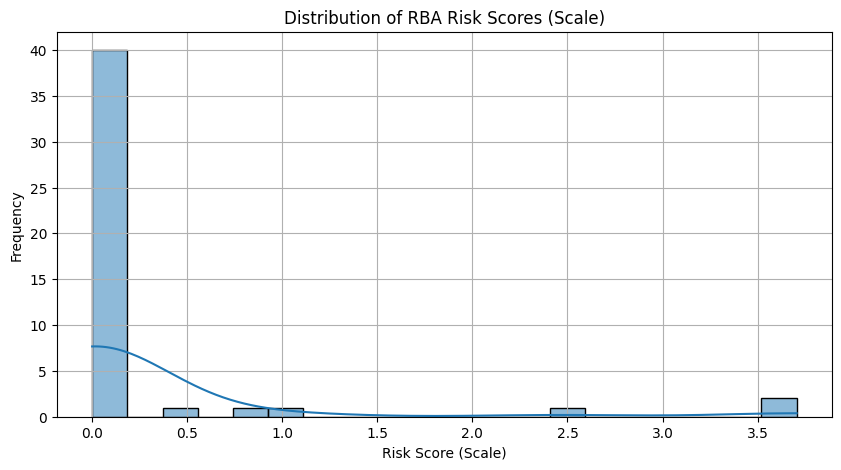

In [45]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
sns.histplot(results_df["risk_score"], bins=20, kde=True)
plt.title("Distribution of RBA Risk Scores (Scale)")
plt.xlabel("Risk Score (Scale)")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()


/var/folders/v2/1lqw28xx561fhh0bww09v91r0000gn/T/ipykernel_3899/2676624884.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=results_df, x="risk_level", palette="Set2", order=["Low", "Medium", "High"])


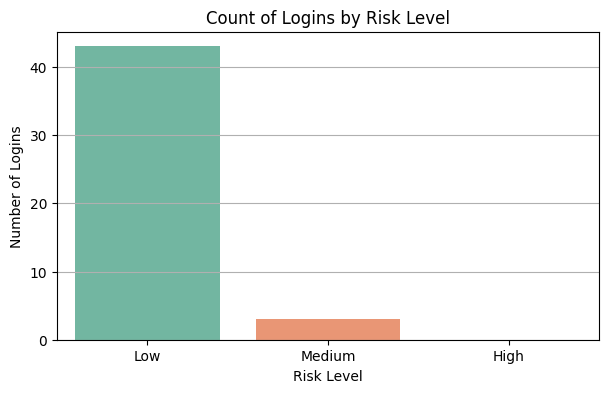

In [46]:
import matplotlib.pyplot as plt
import seaborn as sns

# Risk level distribution count plot
plt.figure(figsize=(7, 4))
sns.countplot(data=results_df, x="risk_level", palette="Set2", order=["Low", "Medium", "High"])
plt.title("Count of Logins by Risk Level")
plt.xlabel("Risk Level")
plt.ylabel("Number of Logins")
plt.grid(True, axis='y')
plt.show()


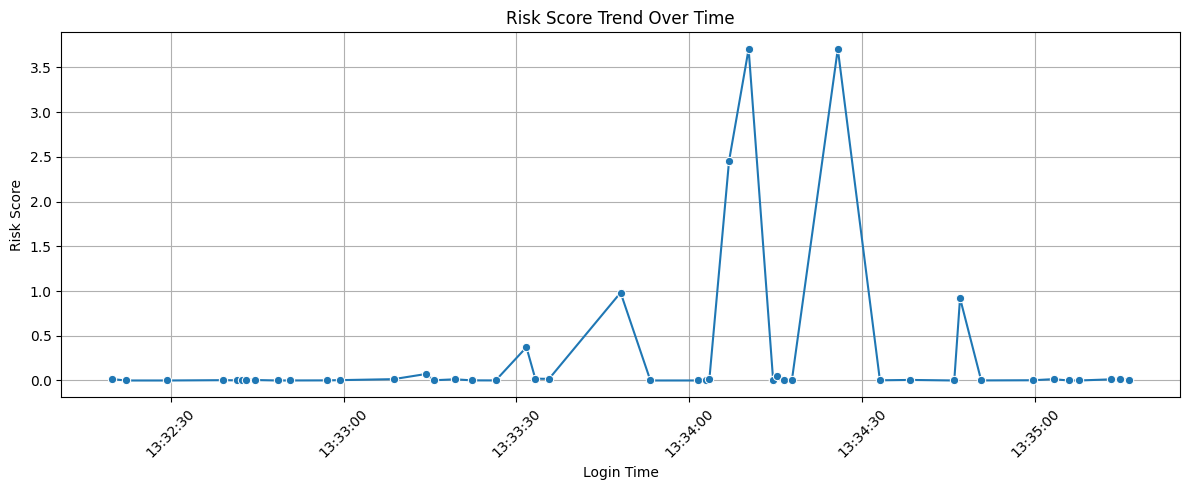

In [47]:
# Sort by sessionStart time
results_df_sorted = results_df.sort_values(by="sessionStart")

plt.figure(figsize=(12, 5))
sns.lineplot(data=results_df_sorted, x="sessionStart", y="risk_score", marker="o")
plt.title("Risk Score Trend Over Time")
plt.xlabel("Login Time")
plt.ylabel("Risk Score")
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


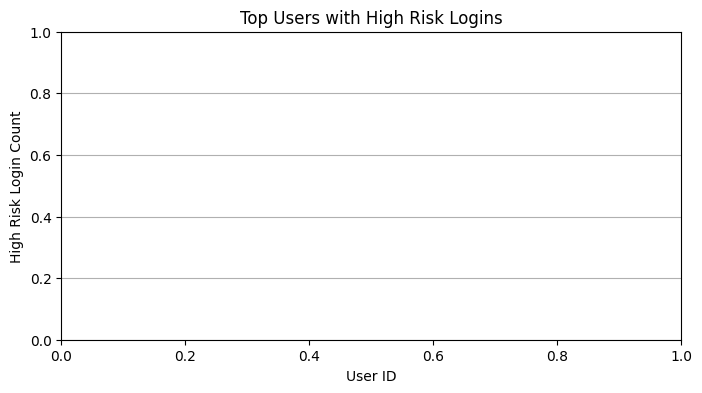

In [48]:
# Filter only high-risk rows
high_risk_logins = results_df[results_df["risk_level"] == "High"]

# Count high-risk logins per user
top_risky_users = high_risk_logins["userid"].value_counts().head(5)

# Bar plot
plt.figure(figsize=(8, 4))
sns.barplot(x=top_risky_users.index.astype(str), y=top_risky_users.values, palette="Reds")
plt.title("Top Users with High Risk Logins")
plt.xlabel("User ID")
plt.ylabel("High Risk Login Count")
plt.grid(True, axis='y')
plt.show()


/var/folders/v2/1lqw28xx561fhh0bww09v91r0000gn/T/ipykernel_3899/324756595.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=results_df, x="risk_level", y="risk_score", palette="Pastel1", order=["Low", "Medium", "High"])


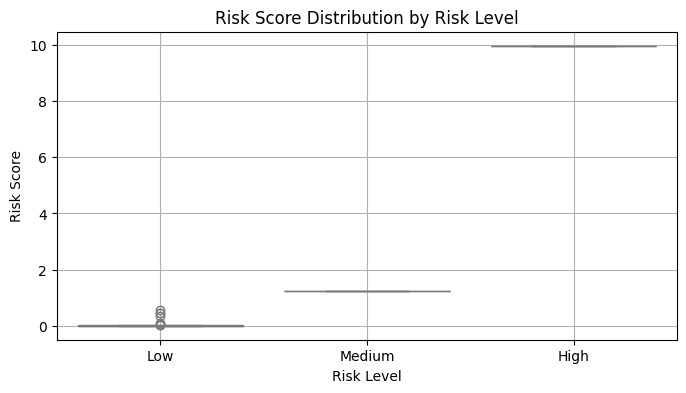

In [43]:
plt.figure(figsize=(8, 4))
sns.boxplot(data=results_df, x="risk_level", y="risk_score", palette="Pastel1", order=["Low", "Medium", "High"])
plt.title("Risk Score Distribution by Risk Level")
plt.xlabel("Risk Level")
plt.ylabel("Risk Score")
plt.grid(True)
plt.show()


In [49]:
# Group by risk level
summary_stats = results_df.groupby("risk_level")["risk_score"].describe()
display(summary_stats)


,count,mean,std,min,25%,50%,75%,max
risk_level,,,,,,,,
Low,43.0,0.060339,0.207233,0.000024,0.000497,0.002792,0.013551,0.982104
Medium,3.0,3.288758,0.721536,2.455600,3.080373,3.705147,3.705337,3.705528


/var/folders/v2/1lqw28xx561fhh0bww09v91r0000gn/T/ipykernel_3899/437912301.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_countries.values, y=top_countries.index, palette="Blues_r")


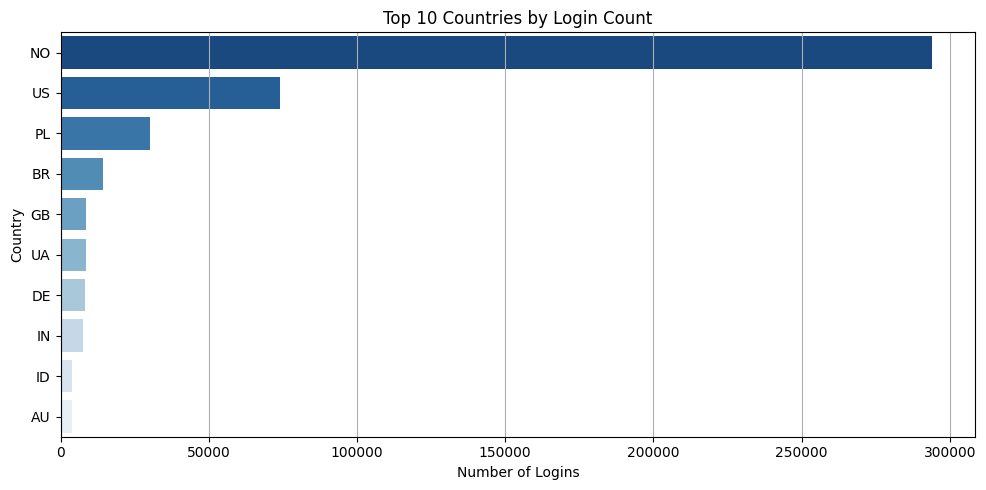

In [50]:
# Count number of logins by country
top_countries = global_logs["ipCountry"].value_counts().head(10)

# Plot
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 5))
sns.barplot(x=top_countries.values, y=top_countries.index, palette="Blues_r")
plt.title("Top 10 Countries by Login Count")
plt.xlabel("Number of Logins")
plt.ylabel("Country")
plt.grid(True, axis='x')
plt.tight_layout()
plt.show()


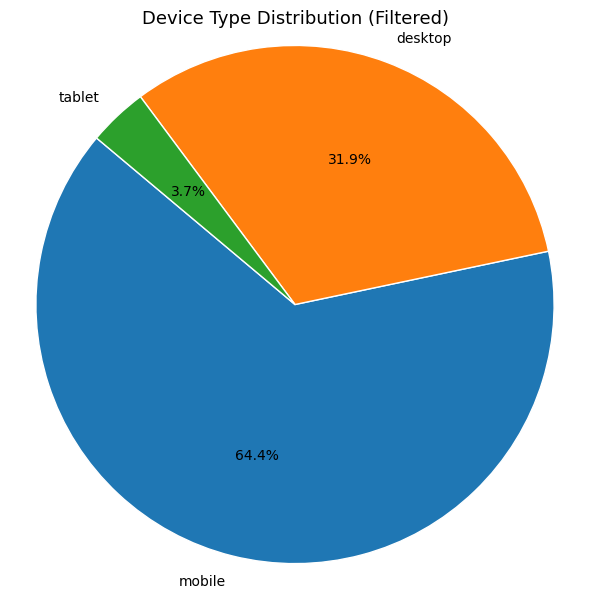

In [28]:
import matplotlib.pyplot as plt

# Count and filter device types
device_counts = global_logs["device_type"].value_counts()
filtered_counts = device_counts[device_counts.index.isin(["mobile", "desktop", "tablet"])]

labels = filtered_counts.index
sizes = filtered_counts.values

# Define the exact colors from your latest chart
colors = ['#1f77b4', '#ff7f0e', '#2ca02c']  # mobile, desktop, tablet

# Create normal-sized pie chart
fig, ax = plt.subplots(figsize=(6, 6))

wedges, texts, autotexts = ax.pie(
    sizes,
    labels=labels,
    autopct='%1.1f%%',
    startangle=140,
    wedgeprops={'edgecolor': 'white', 'linewidth': 1},
    textprops={'fontsize': 10},
    colors=colors
)

plt.title("Device Type Distribution (Filtered)", fontsize=13)
plt.axis('equal')  # Keeps pie circular
plt.tight_layout()
plt.show()
